# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
!ls

images_racoon-1.rar  racoon_images  sample_data  train_labels.csv


In [2]:
import csv
import numpy as np
from PIL import Image, ImageFile
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras import Model
from keras.layers import Conv2D, Reshape
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
import pandas as pd

In [0]:
import tensorflow as tf
from keras.backend import epsilon

In [0]:
import keras

### Change directory

In [3]:
#Mount Google drive (change code for local machine). We need to copy generate_dataset.py script to current directory
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Load the training data from train.csv file

In [4]:
!ls -l

total 25976
-rw------- 1 root root 26574193 Jan 12 05:08 images_racoon-1.rar
drwx------ 3 root root    12288 Jan 12 05:40 racoon_images
drwxr-xr-x 1 root root     4096 Dec 18 16:52 sample_data
-rw------- 1 root root     7913 Jan 12 05:09 train_labels.csv


In [0]:
#Read csv file as pandas dataframe
df = pd.read_csv('train_labels.csv')

In [9]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [10]:
print(df.shape)

(173, 8)


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE=128
INPUT_SHAPE = 128*128*3

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images=np.zeros((len(paths),IMAGE_SIZE,IMAGE_SIZE,3),dtype=np.float32)

In [0]:
for i, x in enumerate(paths):
 img=Image.open('/content/racoon_images/images/'+x)
 img=img.resize((IMAGE_SIZE,IMAGE_SIZE))
 img=img.convert('RGB')
 batch_images[i]=preprocess_input(np.array(img,dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [15]:
model=MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,alpha=1.0)
#Freeze all layers of Pre-trained model
len(model.layers)
for layer in model.layers:
    layer.trainable = False

x=model.layers[-1].output
x=Conv2D(4,kernel_size=4,name='coords')(x)
x=Reshape((4,))(x)

model=Model(inputs=model.input, output=x)












17227776/17225924 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  # This is added back by InteractiveShellApp.init_path()


In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(), metrics=[IoU])

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

In [26]:
model.fit(batch_images,coords,epochs = 30, batch_size = 31, verbose=1)



Epoch 1/30
173/173 [==============================] - 5s 29ms/step - loss: 4068.9326 - IoU: 0.0710
Epoch 2/30
173/173 [==============================] - 4s 24ms/step - loss: 847.3480 - IoU: 0.3964
Epoch 3/30
173/173 [==============================] - 4s 24ms/step - loss: 448.7303 - IoU: 0.5735
Epoch 4/30
173/173 [==============================] - 4s 25ms/step - loss: 610.8535 - IoU: 0.5332
Epoch 5/30
173/173 [==============================] - 4s 24ms/step - loss: 404.3942 - IoU: 0.5836
Epoch 6/30
173/173 [==============================] - 4s 25ms/step - loss: 229.0851 - IoU: 0.6465
Epoch 7/30
173/173 [==============================] - 4s 25ms/step - loss: 210.9776 - IoU: 0.6368
Epoch 8/30
173/173 [==============================] - 4s 24ms/step - loss: 193.5594 - IoU: 0.6558
Epoch 9/30
173/173 [==============================] - 4s 24ms/step - loss: 150.0389 - IoU: 0.7124
Epoch 10/30
173/173 [==============================] - 4s 24ms/step - loss: 136.1958 - IoU: 0.7313
Epoch 11/30
173/

### Pick a test image from the given data

In [0]:
import cv2

raccon_box = cv2.imread('/content/racoon_images/images/raccoon-137.jpg')

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height,image_width,_=raccon_box.shape
image96=cv2.resize(raccon_box,(128,128))
scaled = preprocess_input(np.array(image96,dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [45]:
region = model.predict(np.array([scaled]))[0]
region

array([ 27.396694  ,  -0.43755713, 124.40301   , 128.41339   ],
      dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

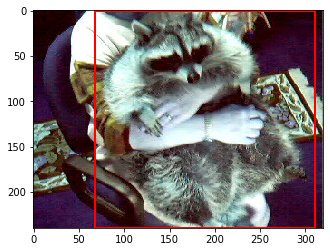

In [46]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(raccon_box)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()